In [1]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /home/jupyter/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [2]:
# Clone the entire repo.
!git clone  https://github.com/Tariq60/LIAR-PLUS
%cd LIAR-PLUS/dataset
!ls

fatal: destination path 'LIAR-PLUS' already exists and is not an empty directory.
/home/jupyter/LIAR-PLUS/dataset
cache		   glove.6B.zip  test.csv    wwm_uncased_L-24_H-1024_A-16
glove.6B.100d.txt  labels.csv	 train2.tsv  wwm_uncased_L-24_H-1024_A-16.zip
glove.6B.200d.txt  LIAR-PLUS	 train.csv
glove.6B.300d.txt  lstm.h5	 val2.tsv
glove.6B.50d.txt   test2.tsv	 val.csv


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-05 16:02:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-05 16:02:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-05 16:02:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [4]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
import os
import numpy as np
import csv
import pandas as pd
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import seaborn as sb


# Defining Headers and Condstants like file names

test_filename = 'test2.tsv'
train_filename = 'train2.tsv'
valid_filename = 'val2.tsv'
header = ['id','label','statement','subjects','speaker','job_title','state','party','barely_true_counts'
         ,'false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts','venue','justification']

# Reading the data 

train_news = pd.read_csv(train_filename,sep='\t',names=header)
test_news = pd.read_csv(test_filename,sep='\t',names=header)
valid_news = pd.read_csv(valid_filename,sep='\t',names=header)




In [4]:
train_news.head(3)

,id,label,statement,subjects,speaker,job_title,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,venue,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...


In [5]:
print(train_news.shape,valid_news.shape,test_news.shape)

(10240, 15) (1284, 15) (1267, 15)


In [6]:
# Creating a new Column by Combining justification and statement made by the speaker
# In case justification is not available, text column will then be filled by statement only.

train_news['text'] = train_news['statement']+train_news['justification']
train_news['text'] = train_news['text'].fillna(train_news['statement'])

valid_news['text'] = valid_news['statement']+valid_news['justification']
valid_news['text'] = valid_news['text'].fillna(valid_news['statement'])

test_news['text'] = test_news['statement']+test_news['justification']
test_news['text'] = test_news['text'].fillna(test_news['statement'])

In [7]:
label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}
print(label_dict)

train_news['output'] = train_news['label'].apply(lambda x: label_dict[x])
valid_news['output'] = valid_news['label'].apply(lambda x: label_dict[x])
test_news['output'] = test_news['label'].apply(lambda x: label_dict[x])

num_classes = 6

{'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}


In [8]:
#distribution of classes for prediction
def create_distribution(df,col):
    
    return sb.countplot(x=col, data=df, palette='hls')

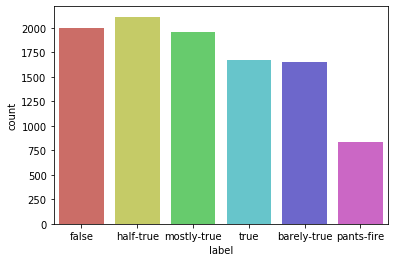

In [9]:
create_distribution(train_news,'label')


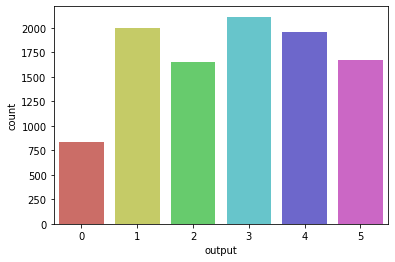

In [10]:
create_distribution(train_news,'output')


In [11]:
train_news.info()
train_news.isna().sum()        
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10240 entries, 0 to 10239
Data columns (total 17 columns):
id                      10240 non-null object
label                   10240 non-null object
statement               10240 non-null object
subjects                10238 non-null object
speaker                 10238 non-null object
job_title               7343 non-null object
state                   8032 non-null object
party                   10238 non-null object
barely_true_counts      10238 non-null float64
false_counts            10238 non-null float64
half_true_counts        10238 non-null float64
mostly_true_counts      10238 non-null float64
pants_on_fire_counts    10238 non-null float64
venue                   10138 non-null object
justification           10156 non-null object
text                    10240 non-null object
output                  10240 non-null int64
dtypes: float64(5), int64(1), object(11)
memory usage: 1.7+ MB


id                         0
label                      0
statement                  0
subjects                   2
speaker                    2
job_title               2897
state                   2208
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
venue                    102
justification             84
text                       0
output                     0
dtype: int64

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec

In [13]:
countV = CountVectorizer()

In [14]:
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)

In [15]:
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [16]:



#building classifier using naive bayes 
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(train_news['text'],train_news['output'])
predicted_nb = nb_pipeline.predict(test_news['text'])
np.mean(predicted_nb == test_news['output'])


0.22336227308603

In [17]:

#building classifier using logistic regression
logR_pipeline = Pipeline([
        ('LogRCV',countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(train_news['text'],train_news['output'])
predicted_LogR = logR_pipeline.predict(test_news['text'])
np.mean(predicted_LogR == test_news['output'])

/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.19810576164167323

In [18]:
#building Linear SVM classfier
svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(train_news['text'],train_news['output'])
predicted_svm = svm_pipeline.predict(test_news['text'])
np.mean(predicted_svm == test_news['output'])


/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.1894238358326756

In [19]:

#using SVM Stochastic Gradient Descent on hinge loss
sgd_pipeline = Pipeline([
        ('svm2CV',countV),
        ('svm2_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
        ])

sgd_pipeline.fit(train_news['text'],train_news['output'])
predicted_sgd = sgd_pipeline.predict(test_news['text'])
np.mean(predicted_sgd == test_news['output'])


0.1894238358326756

In [20]:

#random forest
random_forest = Pipeline([
        ('rfCV',countV),
        ('rf_clf',RandomForestClassifier(n_estimators=150,n_jobs=-1,max_depth=8,min_samples_split=8))
        ])
    
random_forest.fit(train_news['text'],train_news['output'])
predicted_rf = random_forest.predict(test_news['text'])
np.mean(predicted_rf == test_news['output'])

0.20599842146803474


## Now using n-grams

In [21]:

#naive-bayes classifier
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])

nb_pipeline_ngram.fit(train_news['text'],train_news['output'])
predicted_nb_ngram = nb_pipeline_ngram.predict(test_news['text'])
np.mean(predicted_nb_ngram == test_news['output'])

0.22415153906866614

In [22]:

#logistic regression classifier
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf',tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_ngram.fit(train_news['text'],train_news['output'])
predicted_LogR_ngram = logR_pipeline_ngram.predict(test_news['text'])
np.mean(predicted_LogR_ngram ==test_news['output'])


/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.2280978689818469

In [23]:

#linear SVM classifier
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC(dual=False))
        ])

svm_pipeline_ngram.fit(train_news['text'],train_news['output'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['text'])
np.mean(predicted_svm_ngram == test_news['output'])


0.22730860299921074

In [24]:

#sgd classifier
sgd_pipeline_ngram = Pipeline([
         ('sgd_tfidf',tfidf_ngram),
         ('sgd_clf',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))
         ])

sgd_pipeline_ngram.fit(train_news['text'],train_news['output'])
predicted_sgd_ngram = sgd_pipeline_ngram.predict(test_news['text'])
np.mean(predicted_sgd_ngram == test_news['output'])


0.22099447513812154

In [25]:

#random forest classifier
random_forest_ngram = Pipeline([
        ('rf_tfidf',tfidf_ngram),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=-1))
        ])
    
random_forest_ngram.fit(train_news['text'],train_news['output'])
predicted_rf_ngram = random_forest_ngram.predict(test_news['text'])
np.mean(predicted_rf_ngram == test_news['output'])

0.21862667719021311

In [26]:
print(classification_report(test_news['output'], predicted_nb_ngram))
print(classification_report(test_news['output'], predicted_LogR_ngram))
print(classification_report(test_news['output'], predicted_svm_ngram))
print(classification_report(test_news['output'], predicted_sgd_ngram))
print(classification_report(test_news['output'], predicted_rf_ngram))

test_news['output'].shape


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.26      0.15      0.19       249
           2       0.00      0.00      0.00       212
           3       0.22      0.85      0.35       265
           4       0.22      0.09      0.13       241
           5       0.00      0.00      0.00       208

    accuracy                           0.22      1267
   macro avg       0.12      0.18      0.11      1267
weighted avg       0.14      0.22      0.14      1267

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.22      0.25      0.24       249
           2       0.24      0.05      0.09       212
           3       0.23      0.50      0.32       265
           4       0.22      0.29      0.25       241
           5       0.24      0.06      0.10       208

    accuracy                           0.23      1267
   macro avg       0.19

/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(1267,)

In [27]:
#logistic regression parameters
parameters = {'LogR_tfidf__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               'LogR_tfidf__use_idf': (True, False),
               'LogR_tfidf__smooth_idf': (True, False)
}

gs_clf = GridSearchCV(logR_pipeline_ngram, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_news['statement'],train_news['output'])

predicted = gs_clf.estimator.predict(test_news['text'])
np.mean(predicted == test_news['output'])


/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.2280978689818469

In [28]:

#running both random forest and logistic regression models again with best parameter found with GridSearch method
random_forest_final = Pipeline([
        ('rf_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rf_clf',RandomForestClassifier(n_estimators=300,n_jobs=3,max_depth=10))
        ])
    
random_forest_final.fit(train_news['text'],train_news['output'])
predicted_rf_final = random_forest_final.predict(test_news['text'])
print(np.mean(predicted_rf_final == test_news['output']))
print(classification_report(test_news['output'], predicted_rf_final))


0.20836621941594316
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.22      0.01      0.02       249
           2       0.00      0.00      0.00       212
           3       0.21      0.98      0.34       265
           4       0.33      0.00      0.01       241
           5       0.00      0.00      0.00       208

    accuracy                           0.21      1267
   macro avg       0.13      0.17      0.06      1267
weighted avg       0.15      0.21      0.08      1267



/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
logR_pipeline_final = Pipeline([
        #('LogRCV',countV_ngram),
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])

logR_pipeline_final.fit(train_news['text'],train_news['output'])
predicted_LogR_final = logR_pipeline_final.predict(test_news['text'])
np.mean(predicted_LogR_final == test_news['output'])
#accuracy = 0.62
# print(classification_report(test_news['Label'], predicted_LogR_final))

/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyter/anaconda3/envs/nus/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.23283346487766376